In [144]:
!pip install yfinance
import pandas as pd
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
import yfinance as yf
data=yf.download('TCS.NS',period='max')
df= data.to_csv('subset.csv')

[*********************100%***********************]  1 of 1 completed


In [146]:
if os.path.exists("subset.csv"):
    df = pd.read_csv("subset.csv", index_col=0)
else:
    df = yf.Ticker("^GSPC")
    df = df.history(period="max")
    df.to_csv("subset.csv")

In [147]:
df.index = pd.to_datetime(df.index)

In [148]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-12,38.724998,40.000000,38.724998,39.700001,28.485003,212976
2002-08-13,39.750000,40.387501,38.875000,39.162498,28.099333,153576
2002-08-14,39.250000,39.250000,35.724998,36.462502,26.162066,822776
2002-08-15,36.462502,36.462502,36.462502,36.462502,26.162066,0
2002-08-16,36.275002,38.000000,35.750000,36.375000,26.099293,811856
...,...,...,...,...,...,...
2023-03-13,3333.000000,3369.800049,3272.000000,3281.949951,3281.949951,1901233
2023-03-14,3280.000000,3304.399902,3209.399902,3214.949951,3214.949951,2670334
2023-03-15,3250.000000,3260.350098,3192.000000,3198.899902,3198.899902,1780522


<Axes: xlabel='Date'>

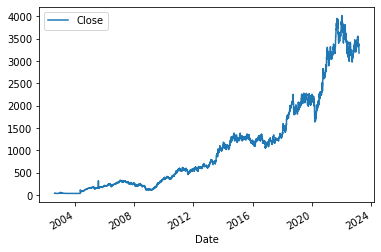

In [149]:
df.plot.line(y="Close", use_index=True)

In [150]:
df["Tomorrow"] = df["Close"].shift(-1)

In [151]:
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

In [152]:
df = df.loc["2005-01-01":].copy()

In [153]:
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
2005-01-03,166.932495,169.587494,166.932495,169.157501,121.691818,4734168,167.657501,0
2005-01-04,168.750000,169.250000,166.645004,167.657501,120.612778,4979104,165.625000,0
2005-01-05,167.524994,167.524994,160.037506,165.625000,119.150528,9604320,165.057495,0
2005-01-06,165.000000,168.250000,161.562500,165.057495,118.742302,8006888,167.494995,1
2005-01-07,166.250000,168.125000,164.082504,167.494995,120.495827,7623136,165.932495,0
...,...,...,...,...,...,...,...,...
2023-03-13,3333.000000,3369.800049,3272.000000,3281.949951,3281.949951,1901233,3214.949951,0
2023-03-14,3280.000000,3304.399902,3209.399902,3214.949951,3214.949951,2670334,3198.899902,0
2023-03-15,3250.000000,3260.350098,3192.000000,3198.899902,3198.899902,1780522,3185.000000,0


In [154]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [155]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47058823529411764

In [156]:
preds

Date
2022-10-25    0
2022-10-27    0
2022-10-28    0
2022-10-31    0
2022-11-01    1
             ..
2023-03-13    0
2023-03-14    0
2023-03-15    0
2023-03-16    0
2023-03-17    0
Length: 100, dtype: int64

<Axes: xlabel='Date'>

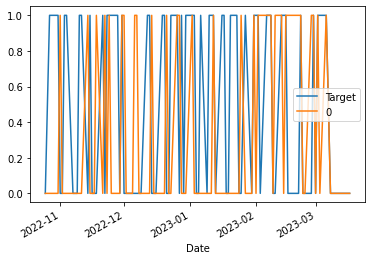

In [157]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [158]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [159]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = [ ]

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [160]:
predictions = backtest(df, model , predictors)

In [161]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5111989459815547

In [162]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.513527
0    0.486473
Name: Target, dtype: float64

In [163]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [164]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])

In [165]:
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2009-01-16,127.175003,129.750000,121.625000,125.750000,95.072678,9790076,125.187500,0,0.992649,0.0,0.970818,2.0,0.981323,27.0,0.651017,115.0,0.562397,488.0
2009-01-19,129.475006,129.475006,121.824997,125.187500,94.647423,6868376,124.112503,0,0.997758,0.0,0.970897,2.0,0.976751,27.0,0.649772,114.0,0.559988,488.0
2009-01-20,123.675003,126.974998,122.500000,124.112503,93.834694,4635196,123.074997,0,0.995688,0.0,0.973584,1.0,0.967024,27.0,0.645819,114.0,0.555282,488.0
2009-01-21,122.750000,125.250000,121.250000,123.074997,93.050255,3669860,124.150002,1,0.995803,0.0,0.983440,0.0,0.958911,26.0,0.642082,113.0,0.550744,488.0
2009-01-22,123.750000,126.012497,120.787498,124.150002,93.863014,4848136,121.537498,0,1.004348,1.0,0.997549,1.0,0.969253,26.0,0.649264,114.0,0.555662,488.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,3333.000000,3369.800049,3272.000000,3281.949951,3281.949951,1901233,3214.949951,0,0.992583,0.0,0.981911,2.0,0.974261,31.0,0.985366,125.0,1.154249,521.0
2023-03-14,3280.000000,3304.399902,3209.399902,3214.949951,3214.949951,2670334,3198.899902,0,0.989687,0.0,0.970982,1.0,0.954491,31.0,0.965695,125.0,1.130217,520.0
2023-03-15,3250.000000,3260.350098,3192.000000,3198.899902,3198.899902,1780522,3185.000000,0,0.997498,0.0,0.977441,0.0,0.949741,31.0,0.961387,124.0,1.124124,519.0


In [166]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [180]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.55] = 1
    preds[preds <.55] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [181]:
predictions = backtest(df, model, new_predictors)

In [182]:
predictions["Predictions"].value_counts()

0.0    647
1.0    349
Name: Predictions, dtype: int64

In [183]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5558739255014327

In [184]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.517068
0    0.482932
Name: Target, dtype: float64

In [185]:
predictions

,Target,Predictions
Date,,
2019-03-11,0,0.0
2019-03-12,0,1.0
2019-03-13,0,0.0
2019-03-14,1,0.0
2019-03-15,0,1.0
...,...,...
2023-03-13,0,0.0
2023-03-14,0,0.0
2023-03-15,0,1.0


In [186]:
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2009-01-16,127.175003,129.750000,121.625000,125.750000,95.072678,9790076,125.187500,0,0.992649,0.0,0.970818,2.0,0.981323,27.0,0.651017,115.0,0.562397,488.0
2009-01-19,129.475006,129.475006,121.824997,125.187500,94.647423,6868376,124.112503,0,0.997758,0.0,0.970897,2.0,0.976751,27.0,0.649772,114.0,0.559988,488.0
2009-01-20,123.675003,126.974998,122.500000,124.112503,93.834694,4635196,123.074997,0,0.995688,0.0,0.973584,1.0,0.967024,27.0,0.645819,114.0,0.555282,488.0
2009-01-21,122.750000,125.250000,121.250000,123.074997,93.050255,3669860,124.150002,1,0.995803,0.0,0.983440,0.0,0.958911,26.0,0.642082,113.0,0.550744,488.0
2009-01-22,123.750000,126.012497,120.787498,124.150002,93.863014,4848136,121.537498,0,1.004348,1.0,0.997549,1.0,0.969253,26.0,0.649264,114.0,0.555662,488.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,3333.000000,3369.800049,3272.000000,3281.949951,3281.949951,1901233,3214.949951,0,0.992583,0.0,0.981911,2.0,0.974261,31.0,0.985366,125.0,1.154249,521.0
2023-03-14,3280.000000,3304.399902,3209.399902,3214.949951,3214.949951,2670334,3198.899902,0,0.989687,0.0,0.970982,1.0,0.954491,31.0,0.965695,125.0,1.130217,520.0
2023-03-15,3250.000000,3260.350098,3192.000000,3198.899902,3198.899902,1780522,3185.000000,0,0.997498,0.0,0.977441,0.0,0.949741,31.0,0.961387,124.0,1.124124,519.0
